In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import make_pipeline
import math 
from scipy.interpolate import make_interp_spline


In [2]:
original = pd.read_csv("Bakery sales.csv")
df = pd.read_csv("Bakery sales.csv")

In [3]:
df.describe()

,Unnamed: 0,ticket_number,Quantity
count,234005.000000,234005.000000,234005.000000
mean,255205.035854,219201.258738,1.538377
std,147501.625992,40053.223896,1.289603
min,0.000000,150040.000000,-200.000000
25%,127979.000000,184754.000000,1.000000
50%,254573.000000,218807.000000,1.000000
75%,382911.000000,253927.000000,2.000000
max,511395.000000,288913.000000,200.000000


In [4]:
df.describe(include="O")

,date,time,article,unit_price
count,234005,234005,234005,234005
unique,600,683,149,123
top,2022-08-14,11:43,TRADITIONAL BAGUETTE,"1,20 €"
freq,997,859,67689,49080


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [6]:
df.loc[df["Quantity"]==df["Quantity"].min()]

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
50553,110378,2021-06-12,09:58,179932.0,CAFE OU EAU,-200.0,"1,00 €"


In [7]:
original.loc[df["Quantity"]==df["Quantity"].max()]

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
50552,110375,2021-06-12,09:58,179931.0,CAFE OU EAU,200.0,"1,00 €"


In [8]:
index_to_drop = [50553, 50552]


df.drop(index=index_to_drop, inplace=True)

In [9]:
df["unit_price"] = df["unit_price"].str.replace(",",".")
df["unit_price"] = df["unit_price"].str.replace(" €","")
df["unit_price"] = df["unit_price"].astype(float)

In [10]:
df.article.unique()

array(['BAGUETTE', 'PAIN AU CHOCOLAT', 'PAIN', 'TRADITIONAL BAGUETTE',
       'CROISSANT', 'BANETTE', 'BANETTINE', 'SPECIAL BREAD', 'COUPE',
       'SAND JB EMMENTAL', 'KOUIGN AMANN', 'BOULE 200G', 'BOULE 400G',
       'GAL FRANGIPANE 6P', 'CAMPAGNE', 'MOISSON', 'CAFE OU EAU',
       'BRIOCHE', 'CEREAL BAGUETTE', 'SEIGLE', 'COMPLET',
       'DIVERS PATISSERIE', 'GAL FRANGIPANE 4P', 'COOKIE', 'FICELLE',
       'PAIN AUX RAISINS', 'GAL POMME 6P', 'GAL POMME 4P', 'FINANCIER X5',
       'VIK BREAD', 'DIVERS VIENNOISERIE', 'GACHE', 'SANDWICH COMPLET',
       'PAIN BANETTE', 'GRAND FAR BRETON', 'QUIM BREAD',
       'SPECIAL BREAD KG', 'GD KOUIGN AMANN', 'BOULE POLKA',
       'DEMI BAGUETTE', 'CHAUSSON AUX POMMES', 'BAGUETTE GRAINE',
       'DIVERS CONFISERIE', 'SUCETTE', 'DIVERS BOULANGERIE',
       'BOISSON 33CL', 'PATES', 'FORMULE SANDWICH', 'DIVERS SANDWICHS',
       'CROISSANT AMANDES', 'PAIN CHOCO AMANDES', 'SACHET VIENNOISERIE',
       'NANTAIS', 'CHOCOLAT', 'PAIN S/SEL', 'FONDANT CHOC

In [11]:
category_mapping = {
    'BAGUETTE': 'Bread', 'PAIN': 'Bread', 'TRADITIONAL BAGUETTE': 'Bread', 'BANETTE': 'Bread', 'BANETTINE': 'Bread',
    'SPECIAL BREAD': 'Bread', 'COUPE': 'Bread', 'BOULE 200G': 'Bread', 'BOULE 400G': 'Bread', 'CAMPAGNE': 'Bread',
    'MOISSON': 'Bread', 'CEREAL BAGUETTE': 'Bread', 'SEIGLE': 'Bread', 'COMPLET': 'Bread', 'FICELLE': 'Bread',
    'PAIN BANETTE': 'Bread', 'QUIM BREAD': 'Bread', 'SPECIAL BREAD KG': 'Bread', 'BOULE POLKA': 'Bread',
    'DEMI BAGUETTE': 'Bread', 'BAGUETTE GRAINE': 'Bread', 'PAIN S/SEL': 'Bread', 'DEMI PAIN': 'Bread',
    'BAGUETTE APERO': 'Bread', 'PAIN DE MIE': 'Bread', 'PAIN GRAINES': 'Bread', 'PAIN NOIR': 'Bread',
    'PAIN AU CHOCOLAT': 'Viennoiseries and Pastries', 'CROISSANT': 'Viennoiseries and Pastries', 'KOUIGN AMANN': 'Viennoiseries and Pastries',
    'BRIOCHE': 'Viennoiseries and Pastries', 'PAIN AUX RAISINS': 'Viennoiseries and Pastries', 'FINANCIER X5': 'Viennoiseries and Pastries',
    'DIVERS VIENNOISERIE': 'Viennoiseries and Pastries', 'GACHE': 'Viennoiseries and Pastries', 'CROISSANT AMANDES': 'Viennoiseries and Pastries',
    'PAIN CHOCO AMANDES': 'Viennoiseries and Pastries', 'SACHET VIENNOISERIE': 'Viennoiseries and Pastries', 'NANTAIS': 'Viennoiseries and Pastries',
    'CHOCOLAT': 'Viennoiseries and Pastries', 'FONDANT CHOCOLAT': 'Viennoiseries and Pastries', 'FINANCIER': 'Viennoiseries and Pastries',
    'VIENNOISE': 'Viennoiseries and Pastries', 'BROWNIES': 'Viennoiseries and Pastries', 'PT NANTAIS': 'Viennoiseries and Pastries',
    'GD NANTAIS': 'Viennoiseries and Pastries', 'TROIS CHOCOLAT': 'Viennoiseries and Pastries', 'PAIN SUISSE PEPITO': 'Viennoiseries and Pastries',
    'GAL FRANGIPANE 6P': 'Cakes and Tarts', 'GAL FRANGIPANE 4P': 'Cakes and Tarts', 'COOKIE': 'Cakes and Tarts', 'GAL POMME 6P': 'Cakes and Tarts',
    'GAL POMME 4P': 'Cakes and Tarts', 'TARTELETTE': 'Cakes and Tarts', 'FLAN': 'Cakes and Tarts', 'PARIS BREST': 'Cakes and Tarts',
    'SAVARIN': 'Cakes and Tarts', 'FLAN ABRICOT': 'Cakes and Tarts', 'MILLES FEUILLES': 'Cakes and Tarts', 'CHOU CHANTILLY': 'Cakes and Tarts',
    'ECLAIR': 'Cakes and Tarts', 'ROYAL 4P': 'Cakes and Tarts', 'TARTE FRUITS 6P': 'Cakes and Tarts', 'TARTE FRUITS 4P': 'Cakes and Tarts',
    'NOIX JAPONAISE': 'Cakes and Tarts', 'ROYAL 6P': 'Cakes and Tarts', 'ECLAIR FRAISE PISTACHE': 'Cakes and Tarts', 'TRIANGLES': 'Cakes and Tarts',
    'TROPEZIENNE': 'Cakes and Tarts', 'TROPEZIENNE FRAMBOISE': 'Cakes and Tarts', 'ROYAL': 'Cakes and Tarts', 'TARTE FRAISE 6P': 'Cakes and Tarts',
    'TARTELETTE FRAISE': 'Cakes and Tarts', 'TARTE FRAISE 4PER': 'Cakes and Tarts', 'FRAISIER': 'Cakes and Tarts', 'NID DE POULE': 'Cakes and Tarts',
    'TARTELETTE CHOC': 'Cakes and Tarts', 'CRUMBLE': 'Cakes and Tarts', 'CAKE': 'Cakes and Tarts', 'ST HONORE': 'Cakes and Tarts',
    'RELIGIEUSE': 'Cakes and Tarts', 'DELICETROPICAL': 'Cakes and Tarts', 'CRUMBLECARAMEL OU PISTAE': 'Cakes and Tarts', 'DOUCEUR D HIVER': 'Cakes and Tarts',
    'ARTICLE 295': 'Cakes and Tarts', 'TARTE FINE': 'Cakes and Tarts', 'ENTREMETS': 'Cakes and Tarts', 'BRIOCHE DE NOEL': 'Cakes and Tarts',
    'FRAMBOISIER': 'Cakes and Tarts', 'BUCHE 4PERS': 'Cakes and Tarts', 'BUCHE 6PERS': 'Cakes and Tarts', 'GD PLATEAU SALE': 'Cakes and Tarts',
    'BUCHE 8PERS': 'Cakes and Tarts', 'PT PLATEAU SALE': 'Cakes and Tarts', 'REDUCTION SUCREES 12': 'Cakes and Tarts', 'REDUCTION SUCREES 24': 'Cakes and Tarts',
    'BOTTEREAU': 'Cakes and Tarts', 'MERINGUE': 'Cakes and Tarts', 'PALMIER': 'Cakes and Tarts', 'PAILLE': 'Cakes and Tarts', 'PALMIER': 'Cakes and Tarts',
    'GUERANDAIS': 'Cakes and Tarts', 'PALET BRETON': 'Cakes and Tarts', 'CARAMEL NOIX': 'Cakes and Tarts', 'MACARON': 'Cakes and Tarts',
    '12 MACARON': 'Cakes and Tarts', 'ARMORICAIN': 'Cakes and Tarts', 'PLAQUE TARTE 25P': 'Cakes and Tarts', 'SABLE F  P': 'Cakes and Tarts',
    'TULIPE': 'Cakes and Tarts', 'TARTELETTE COCKTAIL': 'Cakes and Tarts',
    'SAND JB EMMENTAL': 'Sandwiches and Prepared Meals', 'SANDWICH COMPLET': 'Sandwiches and Prepared Meals', 'FORMULE SANDWICH': 'Sandwiches and Prepared Meals',
    'DIVERS SANDWICHS': 'Sandwiches and Prepared Meals', 'PLATPREPARE6,50': 'Sandwiches and Prepared Meals', 'PLATPREPARE5,50': 'Sandwiches and Prepared Meals',
    'PLATPREPARE7,00': 'Sandwiches and Prepared Meals', 'FORMULE PLAT PREPARE': 'Sandwiches and Prepared Meals', 'PLATPREPARE6,00': 'Sandwiches and Prepared Meals',
    'PLAT 6.50E': 'Sandwiches and Prepared Meals', 'PLAT 7.60E': 'Sandwiches and Prepared Meals', 'PLAT 7.00': 'Sandwiches and Prepared Meals',
    'PLAT': 'Sandwiches and Prepared Meals', 'PLAT 8.30E': 'Sandwiches and Prepared Meals', 'FORMULE PATE': 'Sandwiches and Prepared Meals',
    'DIVERS PATISSERIE': 'Miscellaneous', 'DIVERS CONFISERIE': 'Miscellaneous', 'SUCETTE': 'Miscellaneous', 'DIVERS BOULANGERIE': 'Miscellaneous',
    'BOISSON 33CL': 'Miscellaneous', 'PATES': 'Miscellaneous', 'THE': 'Miscellaneous', 'SACHET DE CROUTON': 'Miscellaneous', 'GRANDE SUCETTE': 'Miscellaneous',
    'DIVERS BOISSONS': 'Miscellaneous', 'TRAITEUR': 'Miscellaneous', 'PT PLATEAU SALE': 'Miscellaneous' , 'CAFE OU EAU': 'Miscellaneous','VIK BREAD': 'Bread',
    'GRAND FAR BRETON': 'Cakes and Tarts','GD KOUIGN AMANN': 'Viennoiseries and Pastries','CHAUSSON AUX POMMES': 'Viennoiseries and Pastries','GAL POIRE CHOCO 6P': 'Cakes and Tarts',
    'GAL POIRE CHOCO 4P': 'Cakes and Tarts',
    'GALETTE 8 PERS': 'Cakes and Tarts',
    'SAND JB': 'Sandwiches and Prepared Meals',
    'BRIOCHETTE': 'Viennoiseries and Pastries',
    '.': 'Miscellaneous',
    'GD FAR BRETON': 'Cakes and Tarts',
    'SACHET DE VIENNOISERIE': 'Viennoiseries and Pastries'
}

df['category'] = df["article"].map(category_mapping)


In [12]:
df["category"].unique()

array(['Bread', 'Viennoiseries and Pastries',
       'Sandwiches and Prepared Meals', 'Cakes and Tarts',
       'Miscellaneous'], dtype=object)

In [13]:
df["Q*P"] = df["Quantity"] * df["unit_price"]

In [14]:
df['time'] = pd.to_datetime(df['time'])

# create a new column with ordinal numbers
df['time_ordinal'] = df['time'].dt.time.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)


C:\Users\spilk\AppData\Local\Temp\ipykernel_18084\2220578665.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])


In [15]:
df

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price,category,Q*P,time_ordinal
0,0,2021-01-02,2024-05-23 08:38:00,150040.0,BAGUETTE,1.0,0.90,Bread,0.90,31080
1,1,2021-01-02,2024-05-23 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,Viennoiseries and Pastries,3.60,31080
2,4,2021-01-02,2024-05-23 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,Viennoiseries and Pastries,2.40,33240
3,5,2021-01-02,2024-05-23 09:14:00,150041.0,PAIN,1.0,1.15,Bread,1.15,33240
4,8,2021-01-02,2024-05-23 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,Bread,6.00,33900
...,...,...,...,...,...,...,...,...,...,...
234000,511387,2022-09-30,2024-05-23 18:52:00,288911.0,COUPE,1.0,0.15,Bread,0.15,67920
234001,511388,2022-09-30,2024-05-23 18:52:00,288911.0,BOULE 200G,1.0,1.20,Bread,1.20,67920
234002,511389,2022-09-30,2024-05-23 18:52:00,288911.0,COUPE,2.0,0.15,Bread,0.30,67920
234003,511392,2022-09-30,2024-05-23 18:55:00,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,Bread,1.30,68100


In [16]:
df.drop(columns=["Unnamed: 0", "date", "time", "article"], inplace=True)

In [17]:
category_dummies = pd.get_dummies(df['category'], dtype=int)

df = pd.concat([df, category_dummies], axis=1)

df.drop(columns=["category"], inplace=True)

In [18]:
df.drop(columns=["unit_price"], inplace=True)

In [19]:
df["Bread"] = df["Bread"]*df["Quantity"]
df["Cakes and Tarts"] = df["Cakes and Tarts"]*df["Quantity"]
df["Miscellaneous"] = df["Miscellaneous"]*df["Quantity"]
df["Sandwiches and Prepared Meals"] = df["Sandwiches and Prepared Meals"]*df["Quantity"]
df["Viennoiseries and Pastries"] = df["Viennoiseries and Pastries"]*df["Quantity"]

In [20]:
df

,ticket_number,Quantity,Q*P,time_ordinal,Bread,Cakes and Tarts,Miscellaneous,Sandwiches and Prepared Meals,Viennoiseries and Pastries
0,150040.0,1.0,0.90,31080,1.0,0.0,0.0,0.0,0.0
1,150040.0,3.0,3.60,31080,0.0,0.0,0.0,0.0,3.0
2,150041.0,2.0,2.40,33240,0.0,0.0,0.0,0.0,2.0
3,150041.0,1.0,1.15,33240,1.0,0.0,0.0,0.0,0.0
4,150042.0,5.0,6.00,33900,5.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
234000,288911.0,1.0,0.15,67920,1.0,0.0,0.0,0.0,0.0
234001,288911.0,1.0,1.20,67920,1.0,0.0,0.0,0.0,0.0
234002,288911.0,2.0,0.30,67920,2.0,0.0,0.0,0.0,0.0
234003,288912.0,1.0,1.30,68100,1.0,0.0,0.0,0.0,0.0


In [81]:
X = df.groupby('ticket_number')[['Quantity', 'Q*P',
       'Bread', 'Cakes and Tarts', 'Miscellaneous',
       'Sandwiches and Prepared Meals', 'Viennoiseries and Pastries']].sum()

In [82]:
X['time_ordinal'] = df.groupby('ticket_number')['time_ordinal'].first()

# Machine learning

Q*P


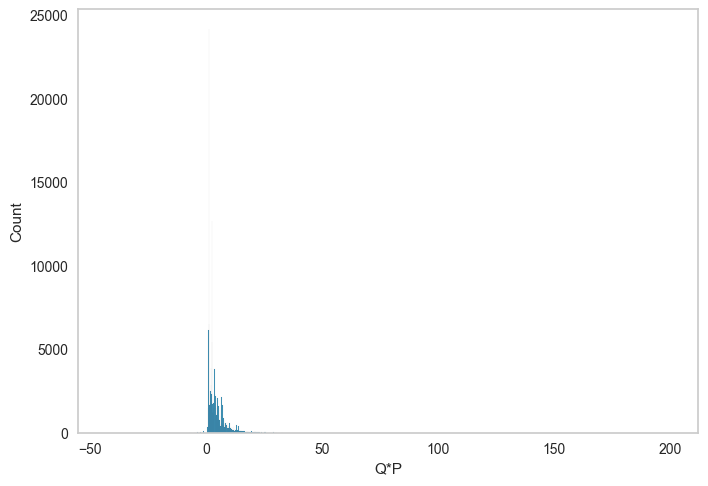

Bread


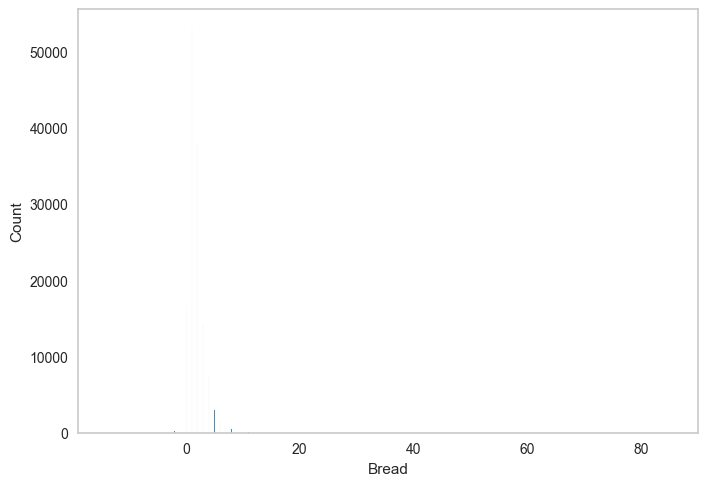

Cakes and Tarts


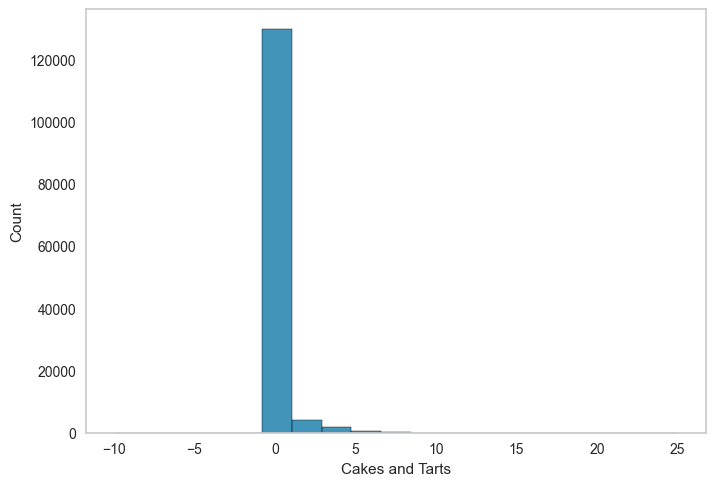

Miscellaneous


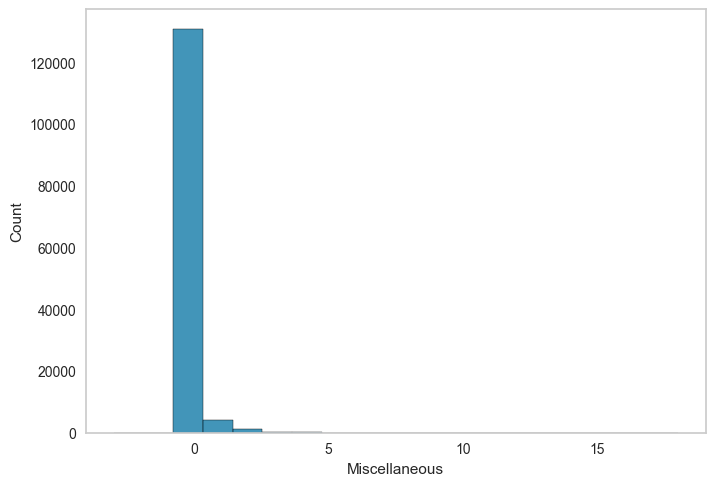

Sandwiches and Prepared Meals


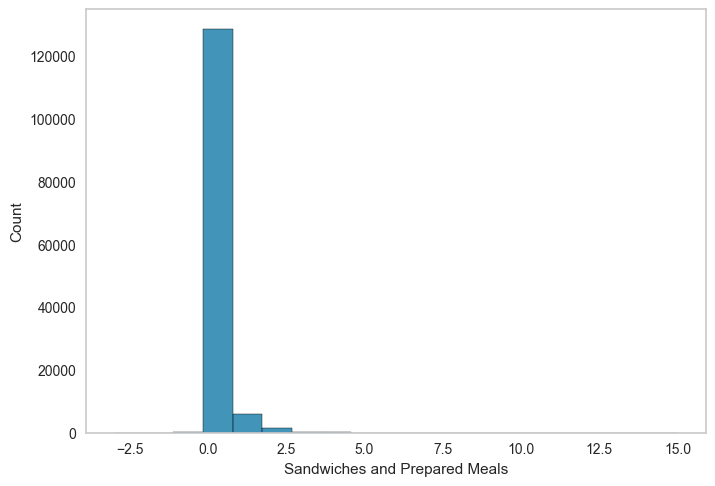

Viennoiseries and Pastries


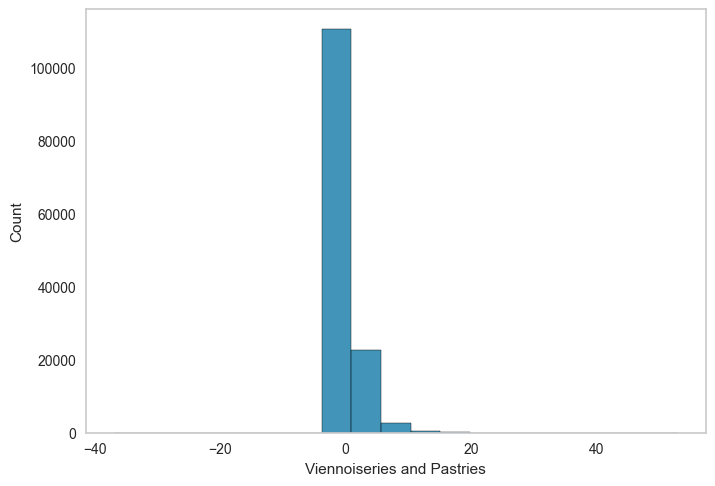

time_ordinal


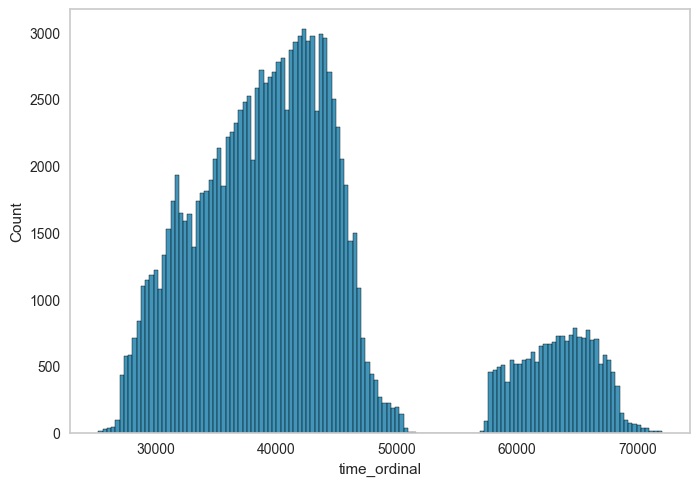

In [23]:
for col in X.columns[1:]:
    print(col)
    sns.histplot(data=X, x=col)
    plt.grid(False)
    plt.show()

In [24]:
scaler = StandardScaler()
decomp = PCA()
pipe = make_pipeline(scaler, decomp)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

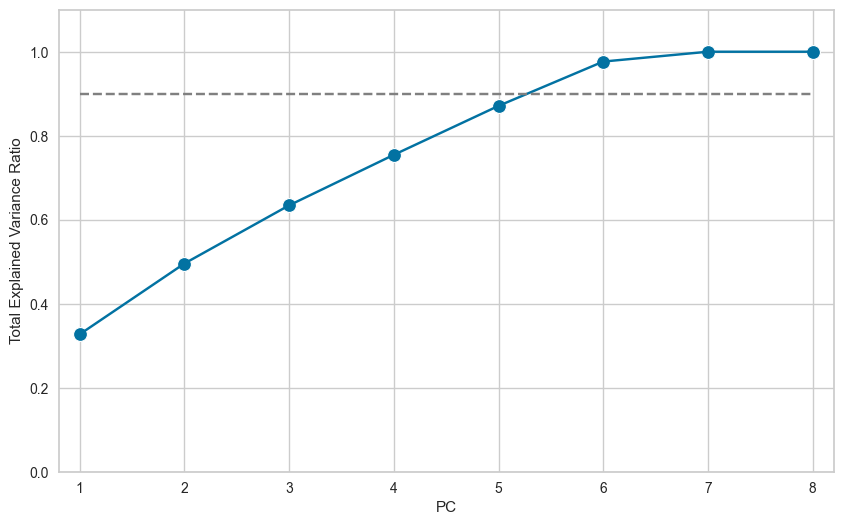

In [25]:
explained_variance = pipe['pca'].explained_variance_ratio_.cumsum()
index = [i+1 for i in range(len(explained_variance))]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x=index, y=explained_variance)
sns.scatterplot(x=index, y=explained_variance, s=100)
plt.xlim((1-0.2, len(explained_variance)+0.2))
plt.ylim((0, 1.1))
x_s, x_e = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(x_s+0.2, x_e))
ax.hlines(y=0.9, xmin=1, xmax=len(explained_variance), color='gray', linestyle='--')
plt.ylabel('Total Explained Variance Ratio')
plt.xlabel('PC')
plt.show()

In [26]:
loadings = pipe["pca"].components_


for i, component in enumerate(loadings):
    
    feature_contributions = np.abs(component)
   
    
    top_contributing_features = np.argsort(feature_contributions)[::-1]
    
    
    print(f"Principal Component {i+1}")
    for feature_idx in top_contributing_features:
        print(f"Feature {df.columns[feature_idx]}: {feature_contributions[feature_idx]}")
        
    print()

Principal Component 1
Feature ticket_number: 0.5966097167661297
Feature Quantity: 0.5366542512246241
Feature Miscellaneous: 0.41531137530698653
Feature Q*P: 0.30172431653267606
Feature time_ordinal: 0.2480333924146354
Feature Sandwiches and Prepared Meals: 0.12801219798027286
Feature Bread: 0.09139997031948402
Feature Cakes and Tarts: 0.07922321438460626

Principal Component 2
Feature Cakes and Tarts: 0.637446595600354
Feature Q*P: 0.5327427181663926
Feature Bread: 0.3673218457427498
Feature Quantity: 0.28231098377056035
Feature time_ordinal: 0.21342478498950912
Feature ticket_number: 0.15724800309841422
Feature Sandwiches and Prepared Meals: 0.15418483975310007
Feature Miscellaneous: 0.034236909102523

Principal Component 3
Feature Sandwiches and Prepared Meals: 0.6386988253220106
Feature time_ordinal: 0.5090272745130517
Feature Miscellaneous: 0.46433275513655703
Feature Q*P: 0.3053137703126151
Feature Cakes and Tarts: 0.12024890075372782
Feature Quantity: 0.09286006431334187
Feature 

# KMeans

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kelbowvisualizer',
                 KElbowVisualizer(ax=<Axes: >,
                                  estimator=KMeans(n_clusters=10, n_init=10)))])

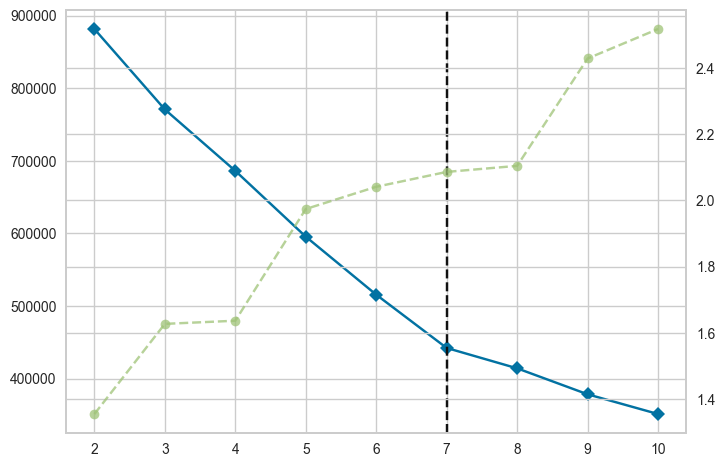

In [27]:
scaler = StandardScaler()
cluster = KElbowVisualizer(KMeans(n_init=10))
pipe = make_pipeline(scaler, cluster)

pipe.fit(X)

In [28]:
scaler = StandardScaler()
cluster = KMeans(n_init=10, n_clusters=7)
pipe = make_pipeline(scaler, cluster)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=7, n_init=10))])

In [83]:
X["clusters"] = pipe["kmeans"].labels_

X

,Quantity,Q*P,Bread,Cakes and Tarts,Miscellaneous,Sandwiches and Prepared Meals,Viennoiseries and Pastries,time_ordinal,clusters
ticket_number,,,,,,,,,
150040.0,4.0,4.50,1.0,0.0,0.0,0.0,3.0,31080,0
150041.0,3.0,3.55,1.0,0.0,0.0,0.0,2.0,33240,0
150042.0,5.0,6.00,5.0,0.0,0.0,0.0,0.0,33900,4
150043.0,5.0,5.10,2.0,0.0,0.0,0.0,3.0,33900,0
150044.0,1.0,1.05,1.0,0.0,0.0,0.0,0.0,34020,0
...,...,...,...,...,...,...,...,...,...
288908.0,2.0,2.70,2.0,0.0,0.0,0.0,0.0,66840,5
288910.0,1.0,1.30,1.0,0.0,0.0,0.0,0.0,67140,5
288911.0,11.0,12.15,11.0,0.0,0.0,0.0,0.0,67920,4


In [84]:
# Convert time_ordinal to actual hourly time
X['time_ordinal'] = X['time_ordinal'].apply(lambda x: '{:02d}:{:02d}'.format(x // 3600, (x % 3600) // 60))

In [102]:
X.rename(columns={"time_ordinal": "time"}, inplace=True)
X.rename(columns={"Q*P": "Sales Revenue"}, inplace=True)

# plot

<Axes: xlabel='clusters', ylabel='count'>

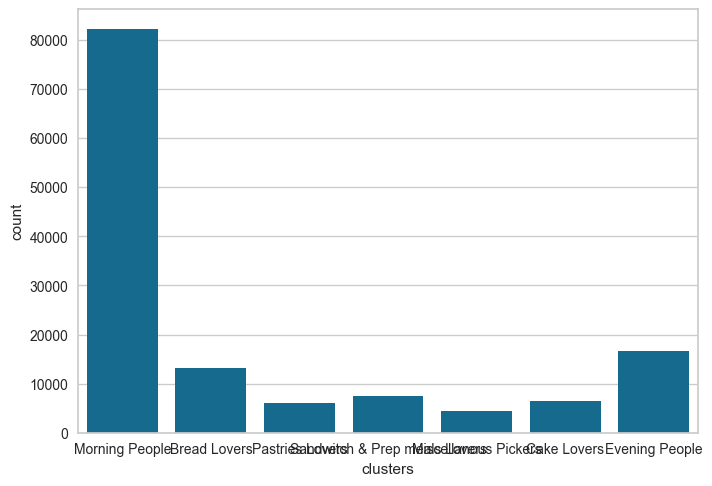

In [103]:
sns.countplot(x="clusters", data=X)

In [33]:
X.columns

Index(['Quantity', 'Q*P', 'Bread', 'Cakes and Tarts', 'Miscellaneous',
       'Sandwiches and Prepared Meals', 'Viennoiseries and Pastries', 'time',
       'clusters'],
      dtype='object')

In [104]:
round(X["Quantity"].mean(),1) , round(X["Sales Revenue"].mean(),1)

(2.6, 4.1)

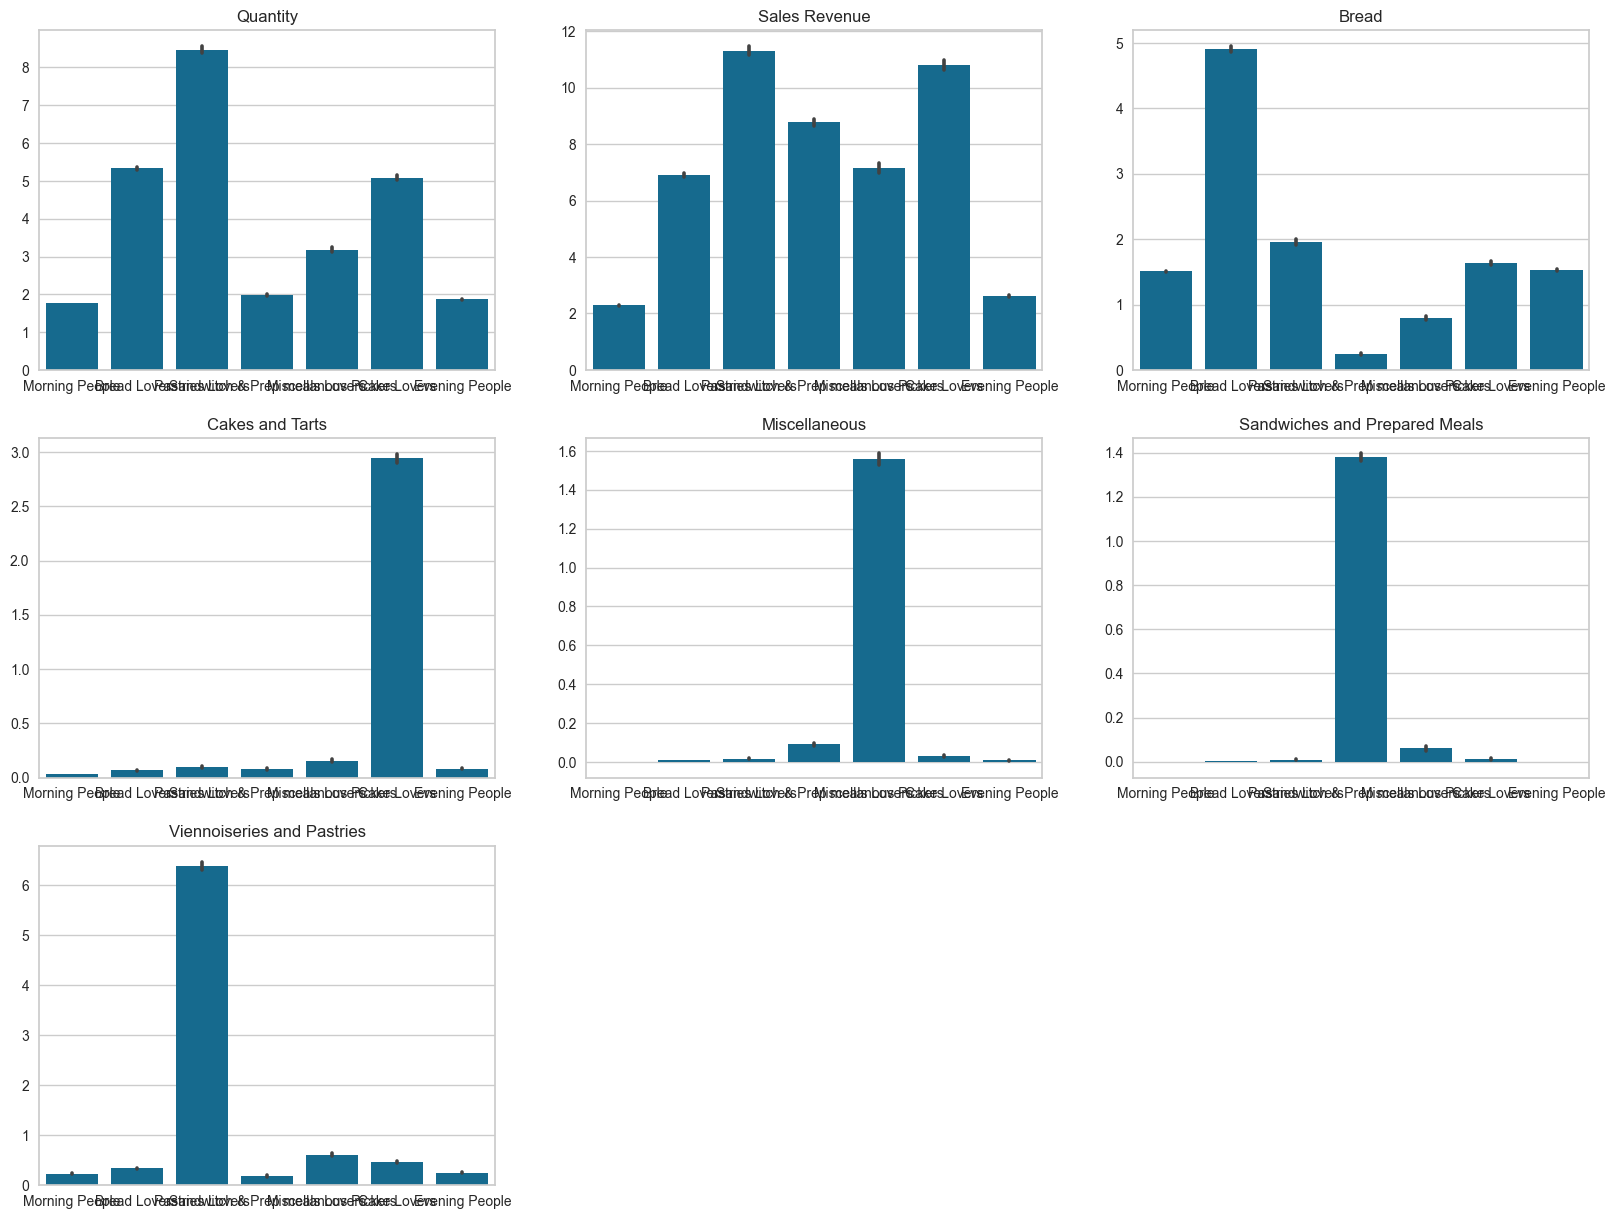

In [105]:
var_list = ['Quantity', 'Sales Revenue', 'Bread', 'Cakes and Tarts', 'Miscellaneous',
       'Sandwiches and Prepared Meals', 'Viennoiseries and Pastries']


rows = math.ceil(len(var_list)/3)


fig, axs = plt.subplots(rows, 3, figsize=(20,5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data=X, x="clusters", y=i, ax=ax)
    ax.set(xlabel="", ylabel="", title=i)
    
for i in axs.flat[::-1][:rows*3-len(var_list)]:
    i.set_axis_off()
    

plt.show()

In [106]:
new_cluster_names = {
    0: "Morning People",
    1: "Cake Lovers",
    2: "Sandwitch & Prep meals Lovers",
    3: "Pastries Lovers",
    4: "Bread Lovers",
    5: "Evening People",
    6: "Miscellanous Pickers"
}

# Replace the cluster numbers with the new names
X['clusters'] = X['clusters'].replace(new_cluster_names)

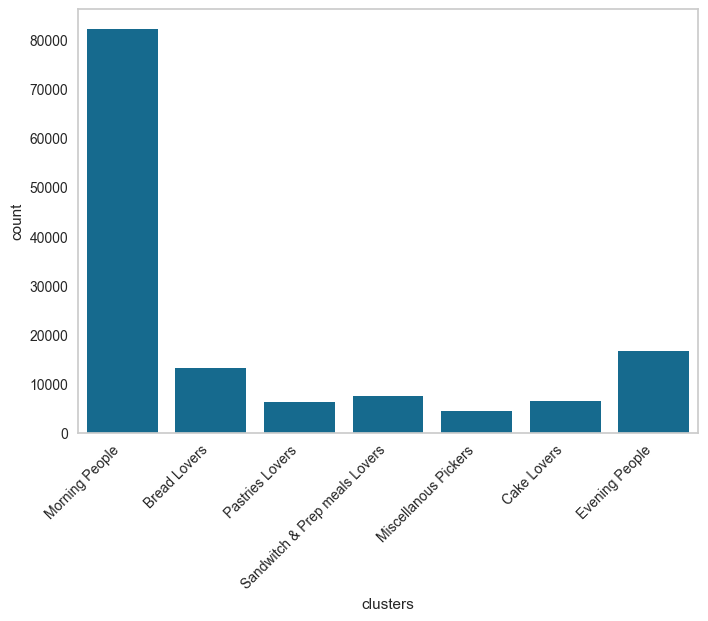

In [107]:
ax = sns.countplot(x="clusters", data=X)

# Get the tick positions
tick_positions = range(len(ax.get_xticklabels()))

# Set the x-labels at the positions of the bars
ax.set_xticks(tick_positions)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(False)

# Show the plot
plt.show()

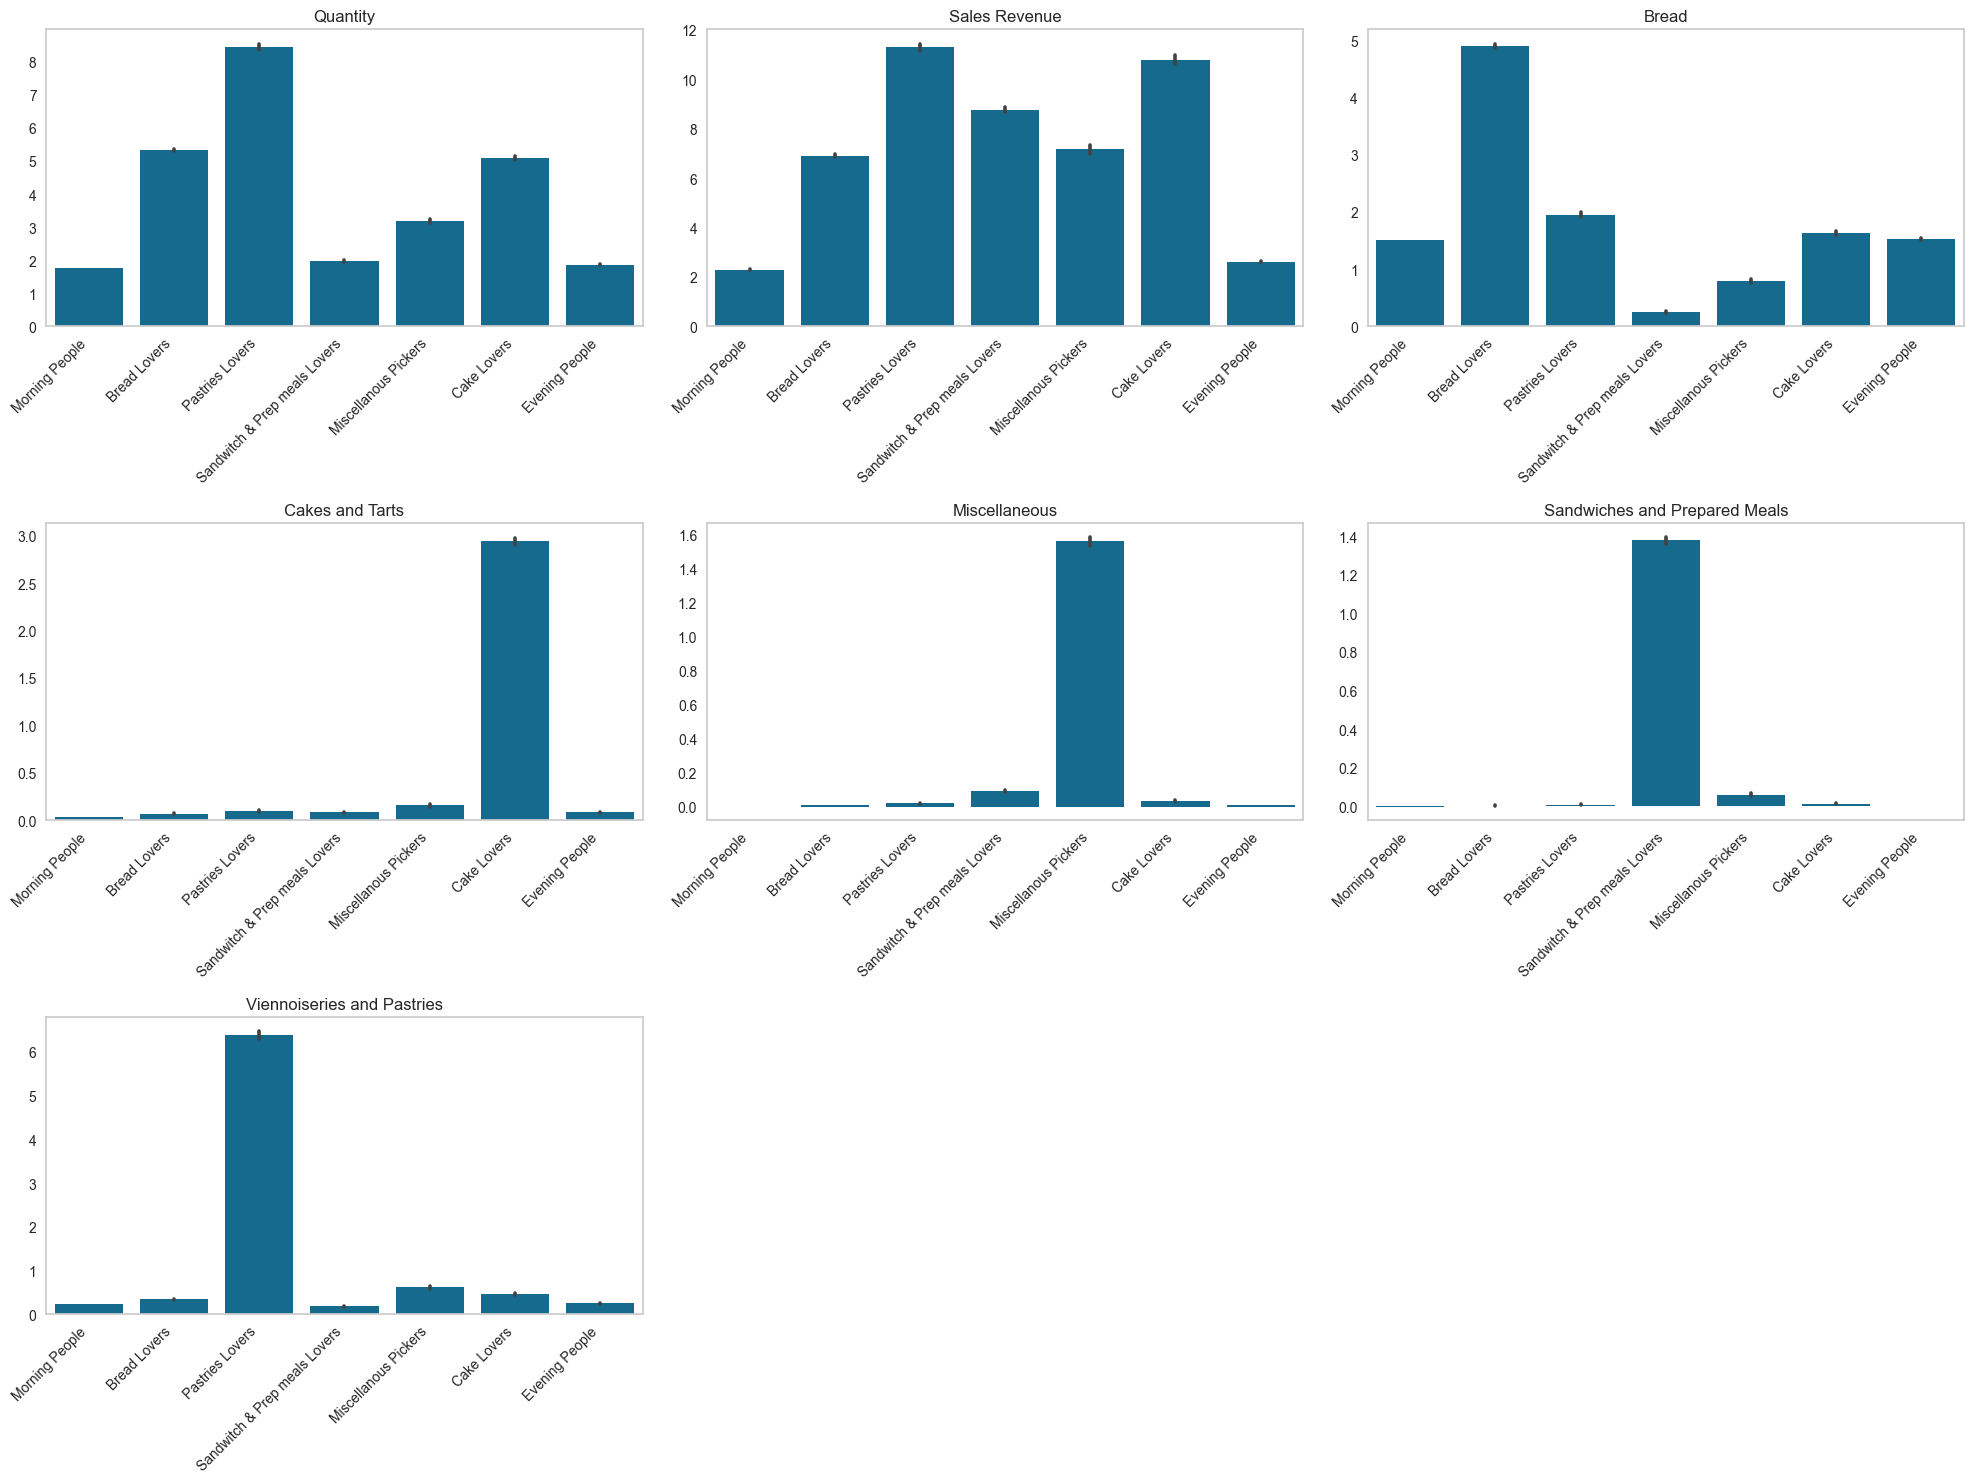

In [108]:
fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data=X, x="clusters", y=i, ax=ax)
    ax.set(xlabel="", ylabel="", title=i)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-ticks
    ax.grid(False)  # Remove the grid
    
    # Align x-labels with bars
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('right')

# Turn off the unused subplots
for i in axs.flat[::-1][:rows*3-len(var_list)]:
    i.set_axis_off()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


## The clusters represent groups of customers with similar purchase behaviors.
- avg quantity = 2.6 
- avg Q*P = 4.1

### Cluster 0:
- it's the biggest grp with almost 90000 customers although they buys avg products(2) with low price(2) and they mostly buy bread products (1,5)


### Cluster 1:
- its the 2nd grp on sales revenue and 3rd in quantities with most interest in Cakes(3) while others are less than 0,2
- almost evenly distributed in the morning hours

- grp 1 is above avg in quantity and sales revenue with most preference in miscellaneous(1,6) while others are less than 0,1
- higher values between 12:00-13:00

### Cluster 2:
- grp 2 is better than 1, but their interest is mostly (almost only) on Sandwiches and Prep meals(1.4)while others are less than 0,1
- higher values between 11:00-13:00

### Cluster 3:
- 4 is the top grp in quantities AND sales revenue with greatest interest in Pastries(6) and Bread(2)


### Cluster 4:
-   Bread products. although they are second to quantities,


### Cluster 5:
- grp 5 is extremly similar to grp 0 but with a little more quantity and sales revenue values.

### Cluster 6:
- Best interest in miscellanous things.

### overall
- the bakery closes for 1 hour between 14:00-15:00
- in the afternoon there are much less customer buying porducts
- there is a reduction of customers after 13:00
- Pastries are more bought 7:00-9:00
- Miscellaneous are more bought 12:00-13:00
- Sandwiches are more bought 11:00-13:00
- Cakes are evenly distributed with peak at 11:00-12:00

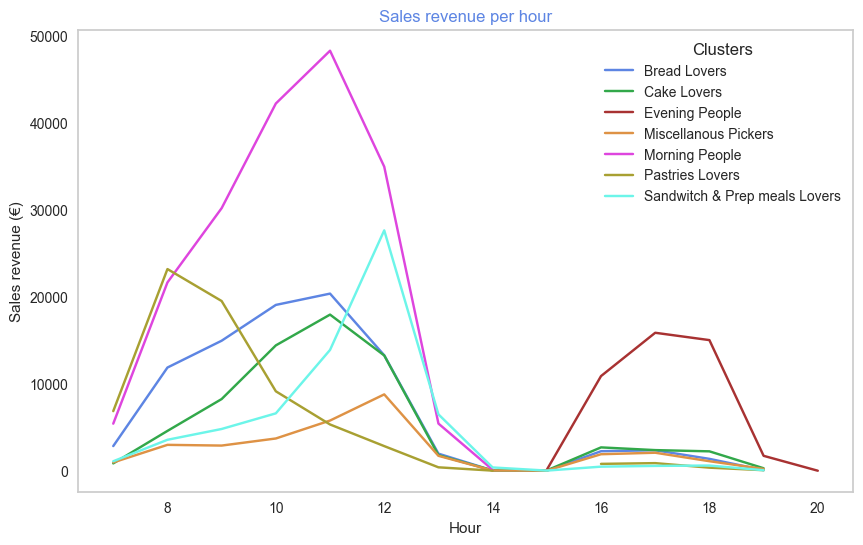

In [116]:
X['time'] = pd.to_datetime(X['time'])

# Extract hour from the 'time' column
X['hour'] = X['time'].dt.hour

grouped = X.groupby(['hour', 'clusters'])['Sales Revenue'].sum().reset_index()

# Pivot the data to get a DataFrame where columns are clusters and rows are hour
pivoted = grouped.pivot(index='hour', columns='clusters', values='Sales Revenue')
colors=['#5d85e3', '#32a84a', '#a83232', '#de9245', '#de45de','#a8a032','#6cf5e9']
# Plot the data
pivoted.plot(kind='line', figsize=(10, 6), color=colors)
plt.title('Sales revenue per hour', color='#5d85e3')
plt.xlabel('Hour')
plt.ylabel('Sales revenue (€)')
plt.legend(title='Clusters')
plt.grid(False)
plt.show()

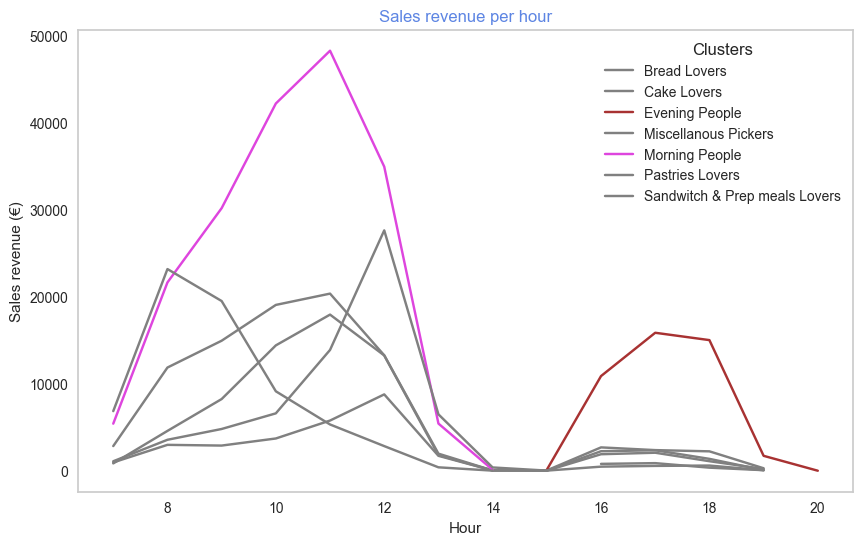

In [115]:
X['time'] = pd.to_datetime(X['time'])

# Extract hour from the 'time' column
X['hour'] = X['time'].dt.hour

grouped = X.groupby(['hour', 'clusters'])['Sales Revenue'].sum().reset_index()

# Pivot the data to get a DataFrame where columns are clusters and rows are hour
pivoted = grouped.pivot(index='hour', columns='clusters', values='Sales Revenue')
colors=['#808080', '#808080', '#a83232', '#808080', '#de45de','#808080','#808080']
# Plot the data
pivoted.plot(kind='line', figsize=(10, 6), color=colors)
plt.title('Sales revenue per hour', color='#5d85e3')
plt.xlabel('Hour')
plt.ylabel('Sales revenue (€)')
plt.legend(title='Clusters')
plt.grid(False)
plt.show()